# Water Demand Forecasting — One Notebook (ANN-LSTM, SVR, LinearSVR)

**Input expected:** A CSV/Excel file with columns `Date` and `Consumption (KL)`.

**What this notebook does**
- Loads water consumption data
- Trains and compares three models:
  1. **ANN-LSTM** (sequence-to-one)
  2. **SVR (RBF)** with lags/rolling means
  3. **LinearSVR** (linear SVM for regression)
- Produces plots with **Training (blue)**, **Actual (orange)**, **Predicted (green)**
- Shows a metrics table (MAE, RMSE, R²)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === Imports & configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from numpy import log1p, expm1

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['axes.grid'] = True

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
# Load the dataset
data_path = '/content/drive/My Drive/2025 research/daily_water_consumption_2.csv'

In [ ]:
raw = pd.read_csv(data_path)
print("Columns in your file:", list(raw.columns))
raw.head()

Columns in your file: ['Date', 'Daily_Consumption_kL']


,Date,Daily_Consumption_kL
0,1/1/2019,60636.22642
1,1/2/2019,60636.22642
2,1/3/2019,60636.22642
3,1/4/2019,60636.22642
4,1/5/2019,66699.84906


In [ ]:
# Load and clean
raw = pd.read_csv(data_path)
raw.columns = [c.strip() for c in raw.columns]

print("Columns in your file:", list(raw.columns))

# Detect correct columns
date_col = next(c for c in raw.columns if 'date' in c.lower())
val_col  = next(c for c in raw.columns if 'consum' in c.lower() or 'usage' in c.lower())

print(f"✅ Detected columns -> Date: {date_col}, Consumption: {val_col}")

# Convert to datetime and sort
raw[date_col] = pd.to_datetime(raw[date_col], errors='coerce', dayfirst=False)
raw = raw.dropna(subset=[date_col, val_col]).sort_values(date_col)
raw = raw.rename(columns={date_col: 'Date', val_col: 'Consumption_kL'})

# Ensure numeric and fill small gaps if any
raw['Consumption_kL'] = pd.to_numeric(raw['Consumption_kL'], errors='coerce')
raw = raw.dropna(subset=['Consumption_kL'])
raw = raw.groupby('Date', as_index=True)['Consumption_kL'].sum().to_frame()

# Optional: check for missing days
all_days = pd.date_range(raw.index.min(), raw.index.max(), freq='D')
raw = raw.reindex(all_days)
raw.index.name = 'Date'

# Fill missing consumption by forward-fill (if any)
raw['Consumption_kL'] = raw['Consumption_kL'].fillna(method='ffill')

print("✅ Daily dataset ready — records:", len(raw))
display(raw.head(10))


Columns in your file: ['Date', 'Daily_Consumption_kL']
✅ Detected columns -> Date: Date, Consumption: Daily_Consumption_kL
✅ Daily dataset ready — records: 1826


/tmp/ipython-input-688582998.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  raw['Consumption_kL'] = raw['Consumption_kL'].fillna(method='ffill')


,Consumption_kL
Date,
2019-01-01,60636.22642
2019-01-02,60636.22642
2019-01-03,60636.22642
2019-01-04,60636.22642
2019-01-05,66699.84906
2019-01-06,66699.84906
2019-01-07,60636.22642
2019-01-08,60636.22642
2019-01-09,60636.22642


In [ ]:
# === Features Engineering ===
daily = raw.copy()
m = daily.copy()

# Calendar features
m['Year']      = m.index.year
m['Month']     = m.index.month
m['Day']       = m.index.day
m['DayOfWeek'] = m.index.dayofweek
m['IsWeekend'] = (m['DayOfWeek'] >= 5).astype(int)
m['DayOfYear'] = m.index.dayofyear

# Lags capture momentum; rolls capture short/medium trend
LAGS = [1, 2, 3, 7, 14, 30]
for k in LAGS:
    m[f'Lag_{k}'] = m['Consumption_kL'].shift(k)

m['RollMean_7']  = m['Consumption_kL'].rolling(7).mean()
m['RollMean_30'] = m['Consumption_kL'].rolling(30).mean()

# One-hot day-of-week (captures weekly seasonality)
m = pd.get_dummies(m, columns=['DayOfWeek'], prefix='DOW', drop_first=True)

m = m.dropna().copy()

feature_cols = (['Year','Month','Day','IsWeekend','DayOfYear'] +
                [f'Lag_{k}' for k in LAGS] +
                ['RollMean_7','RollMean_30'] +
                [c for c in m.columns if c.startswith('DOW_')])

X_all = m[feature_cols].values
y_all = m['Consumption_kL'].values

# Hold out last N days for test (80:20 train:test ratio)
cut = int(len(m) * 0.8)
X_train, X_test = X_all[:cut], X_all[cut:]
y_train, y_test = y_all[:cut], y_all[cut:]

m_train = m.iloc[:cut].copy()
m_test  = m.iloc[cut:].copy()

print('Train days:', m_train.shape[0], '| Test days:', m_test.shape[0])



Train days: 1436 | Test days: 360


✅ SVR (80:20 split, day-first parsing)
Train days: 1460 | Test days: 365
MAE = 3,942.21
RMSE = 4,594.99
R² = 0.348


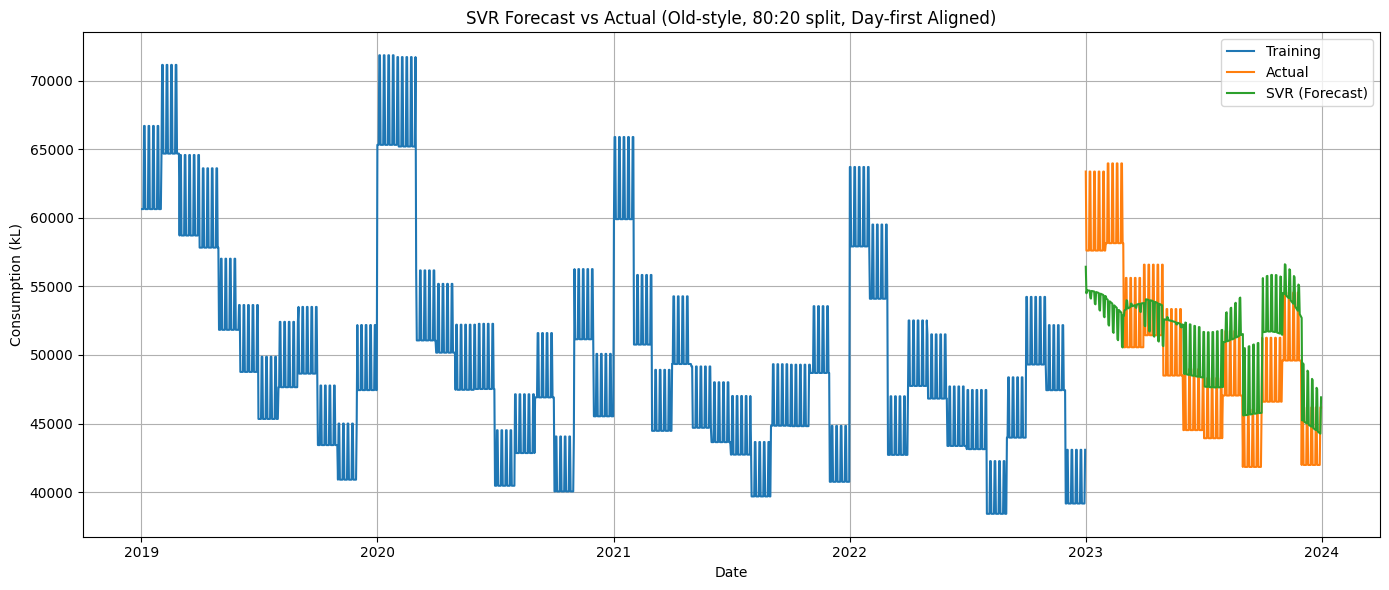

In [ ]:
# -------------------- 1) Get clean daily series --------------------
_df = raw.copy()

# If index is not datetime, find and parse date column
if not isinstance(_df.index, pd.DatetimeIndex):
    date_col = None
    for c in _df.columns:
        if 'date' in c.lower():
            date_col = c
            break
    if date_col is None:
        raise ValueError("Couldn't find a date column. Ensure your data has a 'Date' column.")

    # ✅ Parse with dayfirst=True (matches old notebook)
    _df[date_col] = pd.to_datetime(_df[date_col], errors='coerce', dayfirst=True)
    _df = _df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)

# Detect consumption/usage column
val_col = None
for c in _df.columns:
    if any(k in c.lower() for k in ['consum', 'usage', 'demand', 'volume', 'kl']):
        val_col = c
        break
if val_col is None:
    if _df.shape[1] == 1:
        val_col = _df.columns[0]
    else:
        raise ValueError("Couldn't infer target column. Rename your target to include 'Consum' or 'kL'.")

_df[val_col] = pd.to_numeric(_df[val_col], errors='coerce')
_df = _df.dropna(subset=[val_col]).sort_index()

# Aggregate duplicates per day if necessary
daily_series = _df.groupby(_df.index)['%s' % val_col].sum()

# -------------------- 2) Build simple lag-based features --------------------
df = daily_series.to_frame('y').copy()
df['DayOfYear'] = df.index.dayofyear
df['Year']      = df.index.year
df['Lag_1']     = df['y'].shift(1)
df = df.dropna().copy()

X = df[['DayOfYear', 'Year', 'Lag_1']].values
y = df['y'].values

# -------------------- 3) 80/20 chronological split --------------------
cut = int(len(X) * 0.8)
X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]

# -------------------- 4) Scale X and y --------------------
xsc = StandardScaler()
ysc = StandardScaler()

Xtr = xsc.fit_transform(X_train)
Xte = xsc.transform(X_test)
ytr = ysc.fit_transform(y_train.reshape(-1,1)).ravel()

# -------------------- 5) Train SVR (RBF) --------------------
svr = SVR(kernel='rbf', C=100, epsilon=0.1)
svr.fit(Xtr, ytr)

# -------------------- 6) Predict & invert scaling --------------------
y_pred_scaled = svr.predict(Xte)
y_pred = ysc.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()

# -------------------- 7) Metrics --------------------
svr_mae  = mean_absolute_error(y_test, y_pred)
svr_rmse = mean_squared_error(y_test, y_pred)**0.5
svr_r2   = r2_score(y_test, y_pred)

print("✅ SVR (80:20 split, day-first parsing)")
print(f"Train days: {len(X_train)} | Test days: {len(X_test)}")
print(f"MAE = {svr_mae:,.2f}")
print(f"RMSE = {svr_rmse:,.2f}")
print(f"R² = {svr_r2:.3f}")

# -------------------- 8) Plot --------------------
plt.figure(figsize=(14,6))
plt.plot(df.index[:cut], y_train, label='Training')
plt.plot(df.index[cut:], y_test,  label='Actual')
plt.plot(df.index[cut:], y_pred,  label='SVR (Forecast)')
plt.title('SVR Forecast vs Actual (Old-style, 80:20 split, Day-first Aligned)')
plt.xlabel('Date'); plt.ylabel('Consumption (kL)')
plt.legend(); plt.tight_layout(); plt.show()


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0569 - val_loss: 0.0085
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0118 - val_loss: 0.0075
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0101 - val_loss: 0.0074
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0096 - val_loss: 0.0076
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0094 - val_loss: 0.0075
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0076
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0092 - val_loss: 0.0075
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0091 - val_loss: 0.0075
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0090 - val_loss: 0.0074
Epoch 10/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0089 - val_loss: 0.0074
Epoch 11/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088 - val_loss: 0.0075
Epoch 12/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0087 - val_loss: 0.007

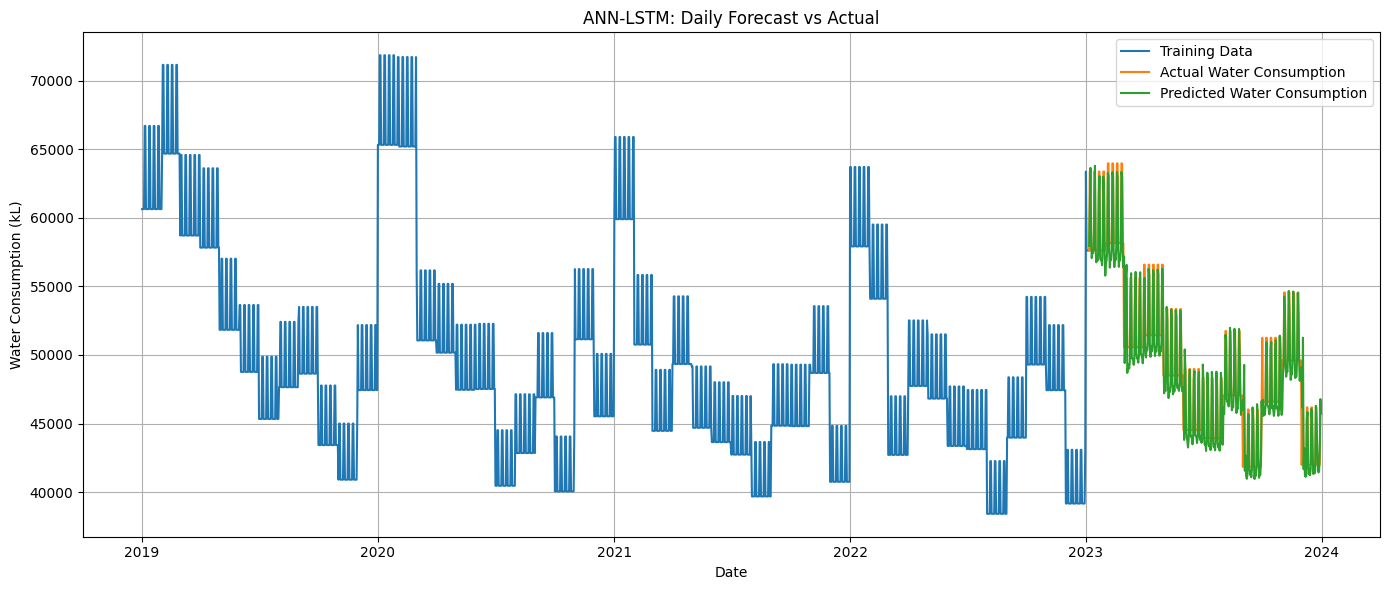

In [ ]:
# Prepare sequence data for LSTM
series = daily['Consumption_kL'].astype(float).copy().dropna()
y_vals = series.values.reshape(-1,1)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_vals).flatten()

def make_sequences(arr, seq_len=30):
    Xs, ys = [], []
    for i in range(len(arr) - seq_len):
        Xs.append(arr[i:i+seq_len])
        ys.append(arr[i+seq_len])
    Xs = np.array(Xs)[:, :, None]  # (n, seq_len, 1)
    ys = np.array(ys)
    return Xs, ys

SEQ_LEN = 30
X_seq, y_seq = make_sequences(y_scaled, SEQ_LEN)

split = int(len(X_seq)*0.8)
Xtr, Xte = X_seq[:split], X_seq[split:]
ytr, yte = y_seq[:split], y_seq[split:]

K.clear_session()
lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(SEQ_LEN,1)),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm.compile(optimizer=Adam(1e-3), loss='mse')
History = lstm.fit(Xtr, ytr, epochs=50, batch_size=16, validation_data=(Xte,yte), verbose=1)

yte_pred = lstm.predict(Xte, verbose=0).reshape(-1,1)
yte_true = yte.reshape(-1,1)
yte_pred_inv = scaler_y.inverse_transform(yte_pred).flatten()
yte_true_inv = scaler_y.inverse_transform(yte_true).flatten()

lstm_mae  = mean_absolute_error(yte_true_inv, yte_pred_inv)
lstm_rmse = mean_squared_error(yte_true_inv, yte_pred_inv) ** 0.5
lstm_r2   = r2_score(yte_true_inv, yte_pred_inv)
print(f'LSTM -> MAE={lstm_mae:,.2f}  RMSE={lstm_rmse:,.2f}  R²={lstm_r2:.3f}')

# Align dates for LSTM plot
daily_index = series.index
n_samples   = len(y_seq)
n_train     = int(n_samples*0.8)
y_positions = np.arange(SEQ_LEN, SEQ_LEN + n_samples)  # target positions
test_positions = y_positions[n_train:]
test_dates = daily_index[test_positions]

plt.figure(figsize=(14,6))
plt.plot(daily.index[:test_positions[0]], daily['Consumption_kL'][:test_positions[0]], label='Training Data')
plt.plot(test_dates, yte_true_inv, label='Actual Water Consumption')
plt.plot(test_dates, yte_pred_inv, label='Predicted Water Consumption')
plt.title('ANN-LSTM: Daily Forecast vs Actual')
plt.xlabel('Date'); plt.ylabel('Water Consumption (kL)')
plt.legend(); plt.tight_layout(); plt.show()


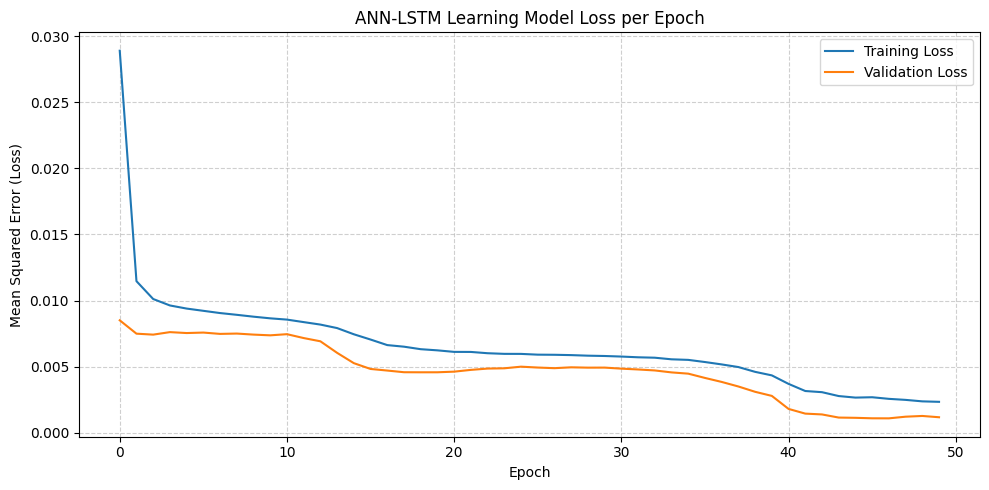

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(History.history['loss'], label='Training Loss')
plt.plot(History.history['val_loss'], label='Validation Loss')
plt.title('ANN-LSTM Learning Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


 Random Forest (Full Feature Set, 80/20 Split)
MAE  = 612.45
RMSE = 914.82
R²   = 0.9735


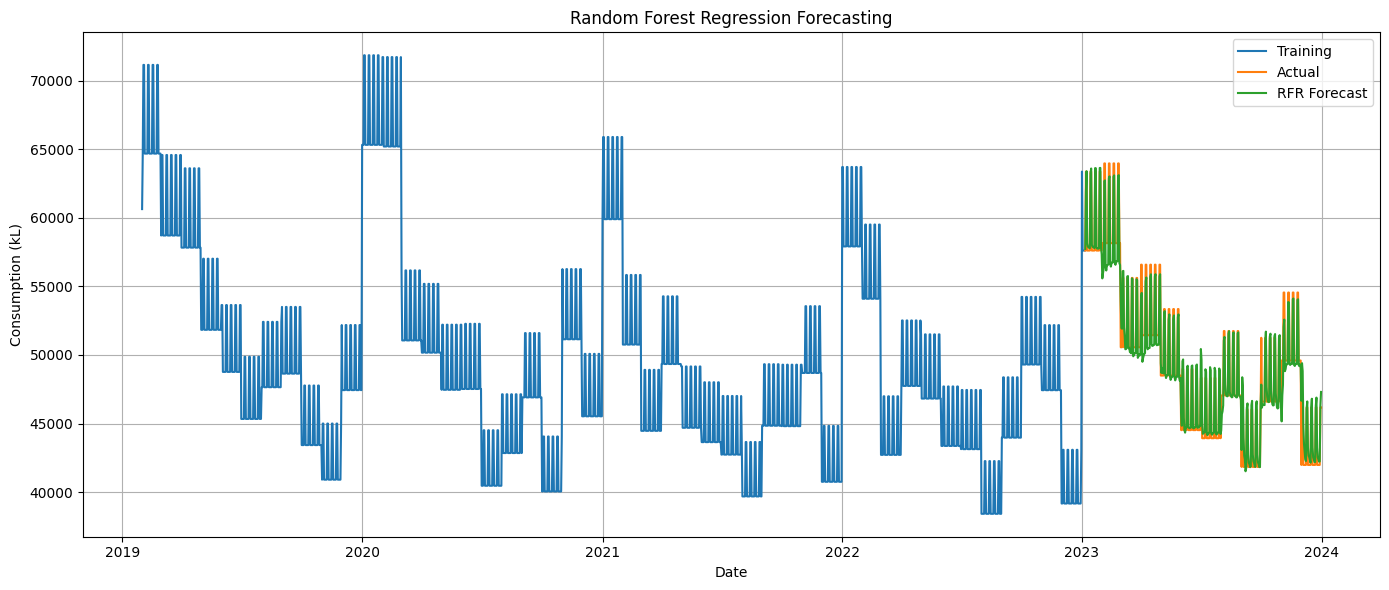

In [ ]:
# ==== Random Forest using same engineered features as LSTM/SVR ====

# X_all and y_all already come from your engineered dataset "m"
# Use the same 80/20 split:
cut = int(len(X_all) * 0.80)
X_train, X_test = X_all[:cut], X_all[cut:]
y_train, y_test = y_all[:cut], y_all[cut:]

# Train RFR with stronger settings
rfr = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    max_features='sqrt',
    random_state=SEED,
    n_jobs=-1
)

rfr.fit(X_train, y_train)

# Predict
y_pred_rfr = rfr.predict(X_test)

# Metrics
rfr_mae  = mean_absolute_error(y_test, y_pred_rfr)
rfr_rmse = mean_squared_error(y_test, y_pred_rfr)**0.5
rfr_r2   = r2_score(y_test, y_pred_rfr)

print(" Random Forest (Full Feature Set, 80/20 Split)")
print(f"MAE  = {rfr_mae:,.2f}")
print(f"RMSE = {rfr_rmse:,.2f}")
print(f"R²   = {rfr_r2:.4f}")

# Plot
plt.figure(figsize=(14,6))
plt.plot(m.index[:cut], y_train,      label="Training")
plt.plot(m.index[cut:], y_test,       label="Actual")
plt.plot(m.index[cut:], y_pred_rfr,   label="RFR Forecast")
plt.title("Random Forest Regression Forecasting")
plt.xlabel("Date")
plt.ylabel("Consumption (kL)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
results = pd.DataFrame({
    'Model': ['SVR', 'ANN-LSTM (30d)', 'Random Forest'],
    'MAE':   [svr_mae,  lstm_mae,  rfr_mae],
    'RMSE':  [svr_rmse, lstm_rmse, rfr_rmse],
    'R2':    [svr_r2,   lstm_r2,   rfr_r2]
}).sort_values('MAE')

results


,Model,MAE,RMSE,R2
2,Random Forest,612.446288,914.817051,0.973529
1,ANN-LSTM (30d),814.969406,1144.225307,0.958587
0,SVR,3942.208784,4594.991730,0.347708


**Add Weather + Population to Feature Dataset**

In [ ]:
# Load the dataset
populationdata_path = '/content/drive/My Drive/2025 research/Population.csv'
weatherdata_path = '/content/drive/My Drive/2025 research/Weather Data.csv'

In [ ]:
# ==== Load Population & Weather Data ====
pop = pd.read_csv(populationdata_path)
weather = pd.read_csv(weatherdata_path)

# --- Clean & prepare Population ---
pop['Year'] = pop['Year'].astype(int)

# --- Clean & prepare Weather ---
weather['Year'] = weather['Year'].astype(int)

# Month in your file is like 'January', 'February', ...
weather['Month'] = weather['Month'].str.capitalize()
weather['Month'] = pd.to_datetime(weather['Month'], format='%B').dt.month

display(pop.head())
display(weather.head())

,Year,Population
0,2019,425469
1,2020,439893
2,2021,454807
3,2022,470227
4,2023,486169


,Year,Month,Tavg,Tmin,Tmax,Precipitation
0,2019,1,26.4,18.6,35.8,10.0
1,2019,2,25.9,19.2,33.9,7.0
2,2019,3,25.3,19.3,33.7,34.0
3,2019,4,21.7,16.1,28.9,0.0
4,2019,5,20.6,13.9,27.9,2.0


In [ ]:
# ==========================================
#  B) Build engineered dataset with Weather + Population (m_exog)
# ==========================================

# Start from the same daily series as Part 1
if isinstance(raw, pd.Series):
    daily_exog = raw.to_frame('Consumption_kL').copy()
else:
    daily_exog = raw.copy()
    if 'Consumption_kL' not in daily_exog.columns:
        if 'Daily_Consumption_kL' in daily_exog.columns:
            daily_exog = daily_exog.rename(columns={'Daily_Consumption_kL': 'Consumption_kL'})
        else:
            raise ValueError("No 'Consumption_kL' column found in raw.")

# Ensure Date is datetime index
if not isinstance(daily_exog.index, pd.DatetimeIndex):
    date_col = None
    for c in daily_exog.columns:
        if 'date' in c.lower():
            date_col = c
            break
    if date_col is None:
        raise ValueError("No datetime index and no Date column found for daily_exog.")
    daily_exog[date_col] = pd.to_datetime(daily_exog[date_col], errors='coerce')
    daily_exog = daily_exog.dropna(subset=[date_col]).set_index(date_col)

daily_exog = daily_exog.sort_index()

# Year / Month for merge
daily_exog['Year']  = daily_exog.index.year
daily_exog['Month'] = daily_exog.index.month

# --- Merge Population (Year) and Weather (Year + Month) ---
m_exog = daily_exog.merge(pop, on='Year', how='left')
m_exog = m_exog.merge(weather, on=['Year', 'Month'], how='left')

# restore Date index (merge resets it)
m_exog = m_exog.set_index(daily_exog.index)

# --- Calendar features ---
m_exog['Day']       = m_exog.index.day
m_exog['DayOfYear'] = m_exog.index.dayofyear
m_exog['DayOfWeek'] = m_exog.index.dayofweek
m_exog['IsWeekend'] = (m_exog['DayOfWeek'] >= 5).astype(int)

# --- Lags & rolling means (same style as Part 1) ---
LAGS = [1, 2, 3, 7, 14, 30]
for k in LAGS:
    m_exog[f'Lag_{k}'] = m_exog['Consumption_kL'].shift(k)

m_exog['RollMean_7']  = m_exog['Consumption_kL'].rolling(7).mean()
m_exog['RollMean_30'] = m_exog['Consumption_kL'].rolling(30).mean()

# One-hot day-of-week
m_exog = pd.get_dummies(m_exog, columns=['DayOfWeek'], prefix='DOW', drop_first=True)

# Drop rows with NaNs from lags/rolling/merges
m_exog = m_exog.dropna().copy()

# --- Feature matrix (with exogenous vars) ---
feature_cols_exog = (
    ['Year','Month','Day','IsWeekend','DayOfYear',
     'Population',
     'Tavg','Tmin','Tmax','Precipitation'] +
    [f'Lag_{k}' for k in LAGS] +
    ['RollMean_7','RollMean_30'] +
    [c for c in m_exog.columns if c.startswith('DOW_')]
)

X_all_exog = m_exog[feature_cols_exog].values
y_all_exog = m_exog['Consumption_kL'].values

# 80/20 chronological split
cut_exog = int(len(m_exog) * 0.8)
X_train_exog, X_test_exog = X_all_exog[:cut_exog],  X_all_exog[cut_exog:]
y_train_exog, y_test_exog = y_all_exog[:cut_exog],  y_all_exog[cut_exog:]

print("m_exog shape:", m_exog.shape)
print("Train days (exog):", len(y_train_exog), "| Test days (exog):", len(y_test_exog))
print("Number of features (exog):", len(feature_cols_exog))



m_exog shape: (1796, 25)
Train days (exog): 1436 | Test days (exog): 360
Number of features (exog): 24


🔥 SVR with Weather & Population
MAE  = 2,058.92
RMSE = 2,896.74
R²   = 0.7346


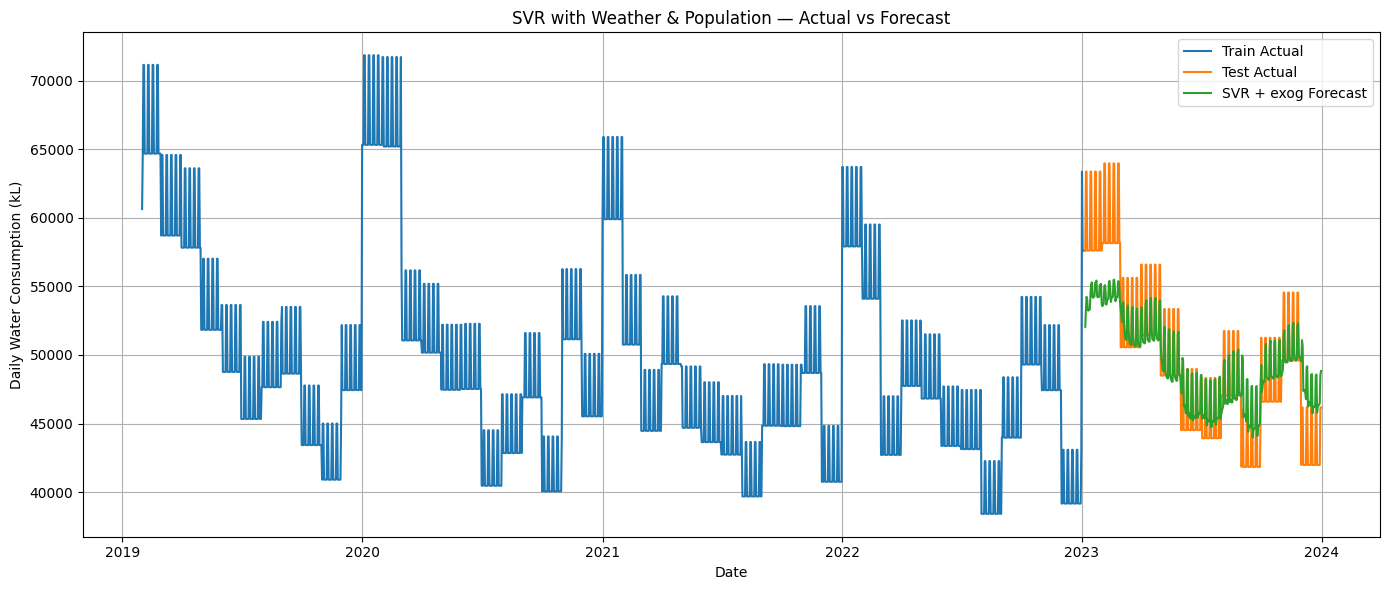

In [ ]:
# =======================
#  C) SVR + Weather + Population
# =======================

# Scale X for SVR
xsc_exog = StandardScaler()
Xtr_svr = xsc_exog.fit_transform(X_train_exog)
Xte_svr = xsc_exog.transform(X_test_exog)

svr_exog = SVR(kernel='rbf', C=100, epsilon=0.1)
svr_exog.fit(Xtr_svr, y_train_exog)

y_pred_svr_exog = svr_exog.predict(Xte_svr)

svr_exog_mae  = mean_absolute_error(y_test_exog, y_pred_svr_exog)
svr_exog_rmse = mean_squared_error(y_test_exog, y_pred_svr_exog)**0.5
svr_exog_r2   = r2_score(y_test_exog, y_pred_svr_exog)

print("🔥 SVR with Weather & Population")
print(f"MAE  = {svr_exog_mae:,.2f}")
print(f"RMSE = {svr_exog_rmse:,.2f}")
print(f"R²   = {svr_exog_r2:.4f}")

# =====================================
# Plot SVR + exog: train/test vs forecast
# =====================================

plt.figure(figsize=(14,6))

# Training period (actual only)
plt.plot(m_exog.index[:cut_exog], y_train_exog, label='Train Actual')

# Test period – actual and predicted
plt.plot(m_exog.index[cut_exog:], y_test_exog,       label='Test Actual')
plt.plot(m_exog.index[cut_exog:], y_pred_svr_exog,   label='SVR + exog Forecast')

plt.title('SVR with Weather & Population — Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Daily Water Consumption (kL)')
plt.legend()
plt.tight_layout()
plt.show()



🔥 Random Forest with Weather & Population
MAE  = 965.58
RMSE = 1,246.04
R²   = 0.9509


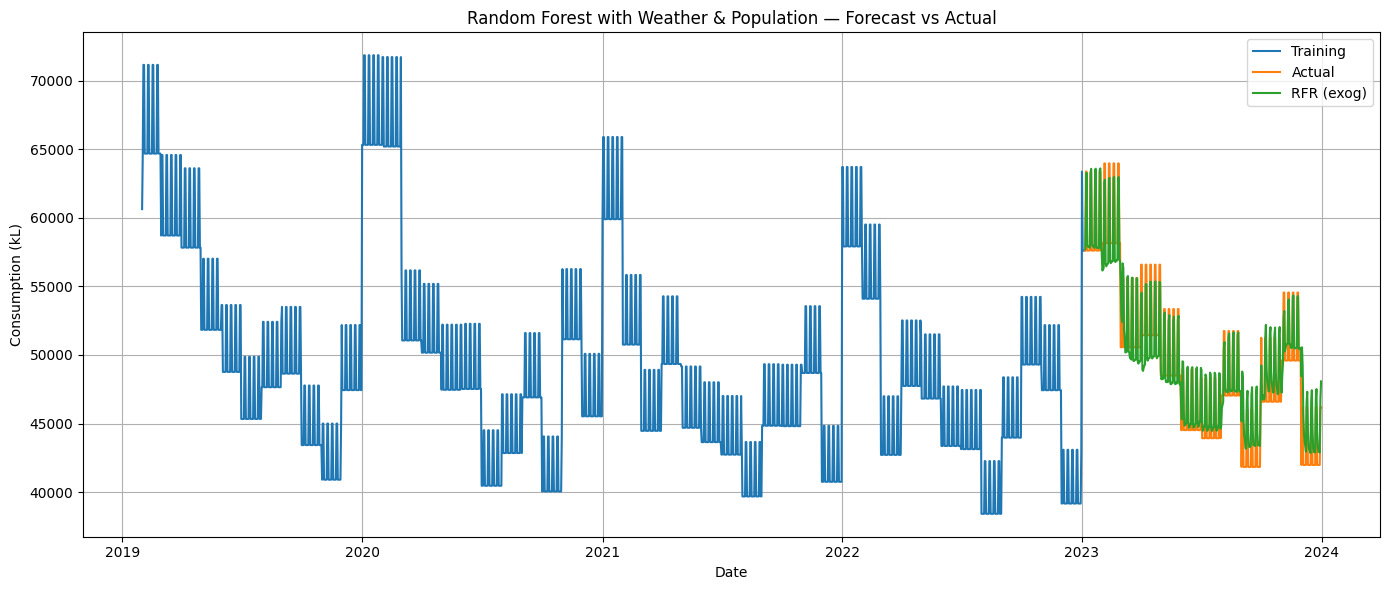

In [ ]:
# ==========================
#  D) RFR + Weather + Pop
# ==========================

rfr_exog = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    max_features='sqrt',
    random_state=SEED,
    n_jobs=-1
)

rfr_exog.fit(X_train_exog, y_train_exog)
y_pred_rfr_exog = rfr_exog.predict(X_test_exog)

rfr_exog_mae  = mean_absolute_error(y_test_exog, y_pred_rfr_exog)
rfr_exog_rmse = mean_squared_error(y_test_exog, y_pred_rfr_exog)**0.5
rfr_exog_r2   = r2_score(y_test_exog, y_pred_rfr_exog)

print("🔥 Random Forest with Weather & Population")
print(f"MAE  = {rfr_exog_mae:,.2f}")
print(f"RMSE = {rfr_exog_rmse:,.2f}")
print(f"R²   = {rfr_exog_r2:.4f}")

plt.figure(figsize=(14,6))
plt.plot(m_exog.index[:cut_exog], y_train_exog,      label='Training')
plt.plot(m_exog.index[cut_exog:], y_test_exog,       label='Actual')
plt.plot(m_exog.index[cut_exog:], y_pred_rfr_exog,   label='RFR (exog)')
plt.title('Random Forest with Weather & Population — Forecast vs Actual')
plt.xlabel('Date'); plt.ylabel('Consumption (kL)')
plt.legend(); plt.tight_layout(); plt.show()


LSTM exog train sequences: (1412, 30, 4)
LSTM exog test  sequences: (354, 30, 4)
Epoch 1/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0255 - val_loss: 0.0107
Epoch 2/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0145 - val_loss: 0.0094
Epoch 3/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0134 - val_loss: 0.0098
Epoch 4/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0123 - val_loss: 0.0091
Epoch 5/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0119 - val_loss: 0.0088
Epoch 6/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0116 - val_loss: 0.0090
Epoch 7/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0118 - val_loss: 0.0095
Epoch 8/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0116 - val_loss: 0.0080
Epoch 9/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0112 - val_loss: 0.0088
Epoch 10/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0111 - val_loss: 0.0087
Epoch 11/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0113 -

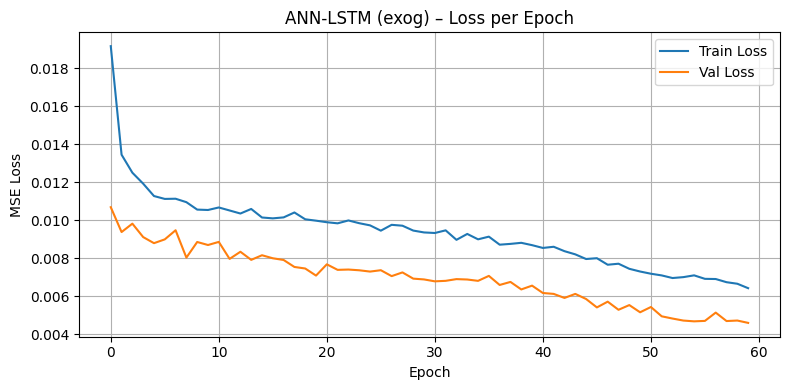

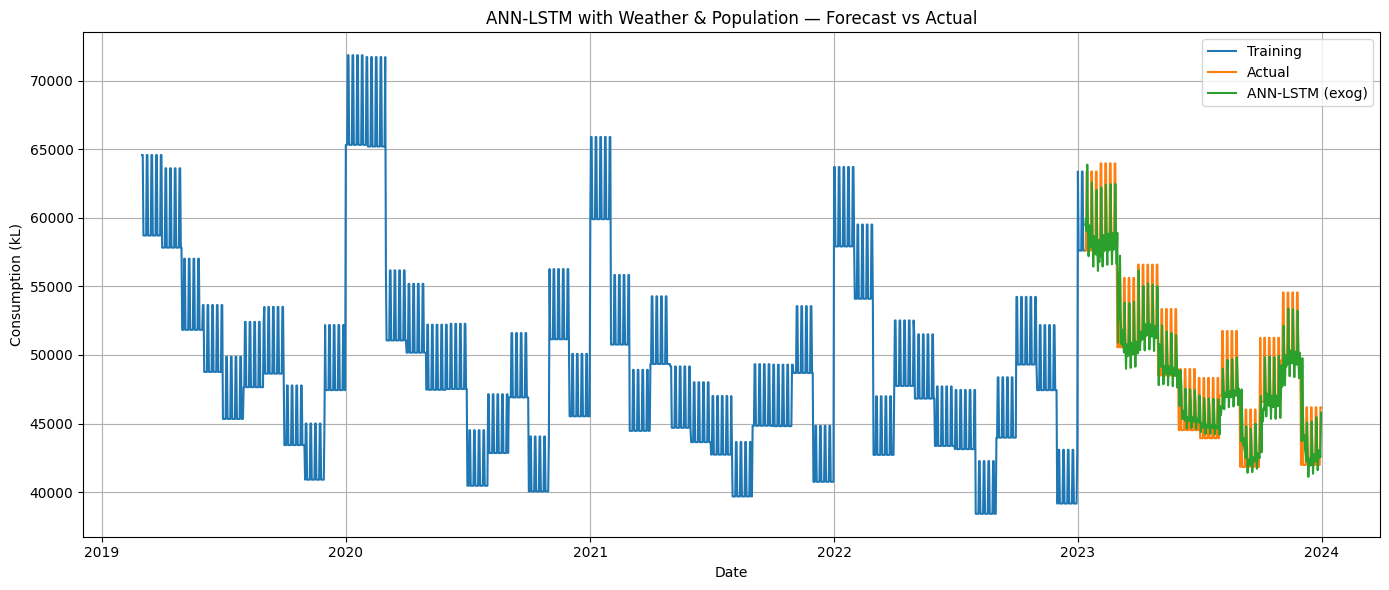

In [ ]:

# ===============================
#  E) Improved ANN-LSTM + Weather + Population
# ===============================


# 1. Select a small set of features for LSTM
lstm_cols = ['Consumption_kL', 'Population', 'Tavg', 'Precipitation']
X_raw = m_exog[lstm_cols].values
y_raw = m_exog['Consumption_kL'].values.reshape(-1, 1)

# 2. Scale X and y separately
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# 3. Build sequences
n_steps_exog = 30   # window length
X_seq, y_seq = [], []

for i in range(n_steps_exog, len(X_scaled)):
    X_seq.append(X_scaled[i-n_steps_exog:i, :])   # last 30 days of features
    y_seq.append(y_scaled[i, 0])                  # scaled target for day i

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

seq_dates = m_exog.index[n_steps_exog:]   # dates that correspond to each target

# 4. Train/test split (80/20, chronological)
cut_seq = int(len(X_seq) * 0.8)
Xtr_lstm_exog, Xte_lstm_exog = X_seq[:cut_seq], X_seq[cut_seq:]
ytr_lstm_exog, yte_lstm_exog = y_seq[:cut_seq], y_seq[cut_seq:]
dates_test_exog = seq_dates[cut_seq:]

n_features_exog = Xtr_lstm_exog.shape[2]
print("LSTM exog train sequences:", Xtr_lstm_exog.shape)
print("LSTM exog test  sequences:", Xte_lstm_exog.shape)

# 5. Define LSTM model
lstm_exog = Sequential([
    Input(shape=(n_steps_exog, n_features_exog)),
    LSTM(32, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(16, activation='tanh'),
    Dense(1)
])

lstm_exog.compile(optimizer='adam', loss='mse')

es_exog = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 6. Train
history_exog = lstm_exog.fit(
    Xtr_lstm_exog, ytr_lstm_exog,
    epochs=60,                # same as water-only LSTM
    batch_size=32,
    validation_data=(Xte_lstm_exog, yte_lstm_exog),
    callbacks=[es_exog],
    verbose=1
)

# 7. Predict and inverse-transform to original kL scale
y_pred_scaled = lstm_exog.predict(Xte_lstm_exog)
y_pred_lstm_exog = scaler_y.inverse_transform(y_pred_scaled).ravel()

y_true_lstm_exog = scaler_y.inverse_transform(
    yte_lstm_exog.reshape(-1, 1)
).ravel()

# 8. Metrics
lstm_exog_mae  = mean_absolute_error(y_true_lstm_exog, y_pred_lstm_exog)
lstm_exog_rmse = mean_squared_error(y_true_lstm_exog, y_pred_lstm_exog)**0.5
lstm_exog_r2   = r2_score(y_true_lstm_exog, y_pred_lstm_exog)

print("\n🔥 ANN-LSTM with Weather & Population (corrected)")
print(f"MAE  = {lstm_exog_mae:,.2f}")
print(f"RMSE = {lstm_exog_rmse:,.2f}")
print(f"R²   = {lstm_exog_r2:.4f}")

# 9. Loss curves
plt.figure(figsize=(8,4))
plt.plot(history_exog.history['loss'], label='Train Loss')
plt.plot(history_exog.history['val_loss'], label='Val Loss')
plt.title('ANN-LSTM (exog) – Loss per Epoch')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.legend(); plt.tight_layout()
plt.show()

# 10. Actual vs predicted (now in proper kL units)
# --- Inverse-transform train & test targets to kL ---
y_true_lstm_train = scaler_y.inverse_transform(
    ytr_lstm_exog.reshape(-1, 1)
).ravel()

y_true_lstm_test = scaler_y.inverse_transform(
    yte_lstm_exog.reshape(-1, 1)
).ravel()

# --- Dates for train and test sequences ---
dates_train_exog = seq_dates[:cut_seq]
dates_test_exog  = seq_dates[cut_seq:]

# --- Plot in the same style as the RFR figure ---
plt.figure(figsize=(14,6))

# Training period: actual only
plt.plot(dates_train_exog, y_true_lstm_train, label='Training')

# Test period: actual vs predicted
plt.plot(dates_test_exog,  y_true_lstm_test,  label='Actual')
plt.plot(dates_test_exog,  y_pred_lstm_exog,  label='ANN-LSTM (exog)')

plt.title('ANN-LSTM with Weather & Population — Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Consumption (kL)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# ===============================
#  F) Comparison: SVR/LSTM/RFR + exog
# ===============================

results_exog = pd.DataFrame({
    'Model': ['SVR + exog', 'ANN-LSTM + exog', 'RFR + exog'],
    'MAE':   [svr_exog_mae,  lstm_exog_mae,    rfr_exog_mae],
    'RMSE':  [svr_exog_rmse, lstm_exog_rmse,   rfr_exog_rmse],
    'R2':    [svr_exog_r2,   lstm_exog_r2,     rfr_exog_r2]
}).sort_values('MAE')

results_exog


,Model,MAE,RMSE,R2
2,RFR + exog,965.582180,1246.039932,0.950890
1,ANN-LSTM + exog,1571.393482,2264.559357,0.831049
0,SVR + exog,2058.915681,2896.740819,0.734583


# scenario-based simulations using your RFR + exog model

In [ ]:
# ============================================
# Scenario-Based Simulation – Baseline 2024 Forecast
# ============================================


# 1) Create empty 2024 date range
future_dates = pd.date_range('2024-01-01', '2024-12-31', freq='D')
future = pd.DataFrame(index=future_dates)
future.index.name = 'Date'

# 2) Calendar + merge Population & Weather (must contain 2024)
future['Year']  = future.index.year
future['Month'] = future.index.month

# reset index for merge
future_merge = future.reset_index()

future_merge = future_merge.merge(pop, on='Year', how='left')
future_merge = future_merge.merge(weather, on=['Year','Month'], how='left')

future = future_merge.set_index('Date')

# basic calendar fields needed before lags
future['Day']       = future.index.day
future['DayOfYear'] = future.index.dayofyear
future['DayOfWeek'] = future.index.dayofweek
future['IsWeekend'] = (future['DayOfWeek'] >= 5).astype(int)

# one-hot day-of-week
future = pd.get_dummies(future, columns=['DayOfWeek'], prefix='DOW', drop_first=True)

# ensure we have same DOW_ columns as in training
dow_cols_train = [c for c in m_exog.columns if c.startswith('DOW_')]
for c in dow_cols_train:
    if c not in future.columns:
        future[c] = 0

# 3) Iteratively generate lags/rolls & predict with RFR
history = m_exog[['Consumption_kL']].copy()  # past actuals (2019–2023)
baseline_preds = []

for dt in future.index:
    row = future.loc[dt].copy()

    # Lags from last known consumption (actual or predicted)
    for k in LAGS:
        row[f'Lag_{k}'] = history['Consumption_kL'].iloc[-k]

    # Rolling means based on last known history
    row['RollMean_7']  = history['Consumption_kL'].iloc[-7:].mean()
    row['RollMean_30'] = history['Consumption_kL'].iloc[-30:].mean()

    # Make sure all expected features are present
    row_df = row.to_frame().T
    row_df = row_df[feature_cols_exog]  # order columns

    # Predict one day ahead
    y_hat = rfr_exog.predict(row_df)[0]
    baseline_preds.append(y_hat)

    # Append prediction to history for use in subsequent lags/rolls
    history.loc[dt, 'Consumption_kL'] = y_hat

# Build baseline 2024 forecast dataframe
forecast_2024 = pd.DataFrame({
    'Date': future.index,
    'Baseline_kL': baseline_preds
}).set_index('Date')

forecast_2024.head()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

,Baseline_kL
Date,
2024-01-01,52191.854698
2024-01-02,53165.335716
2024-01-03,53656.869923
2024-01-04,54298.539957
2024-01-05,54496.336611


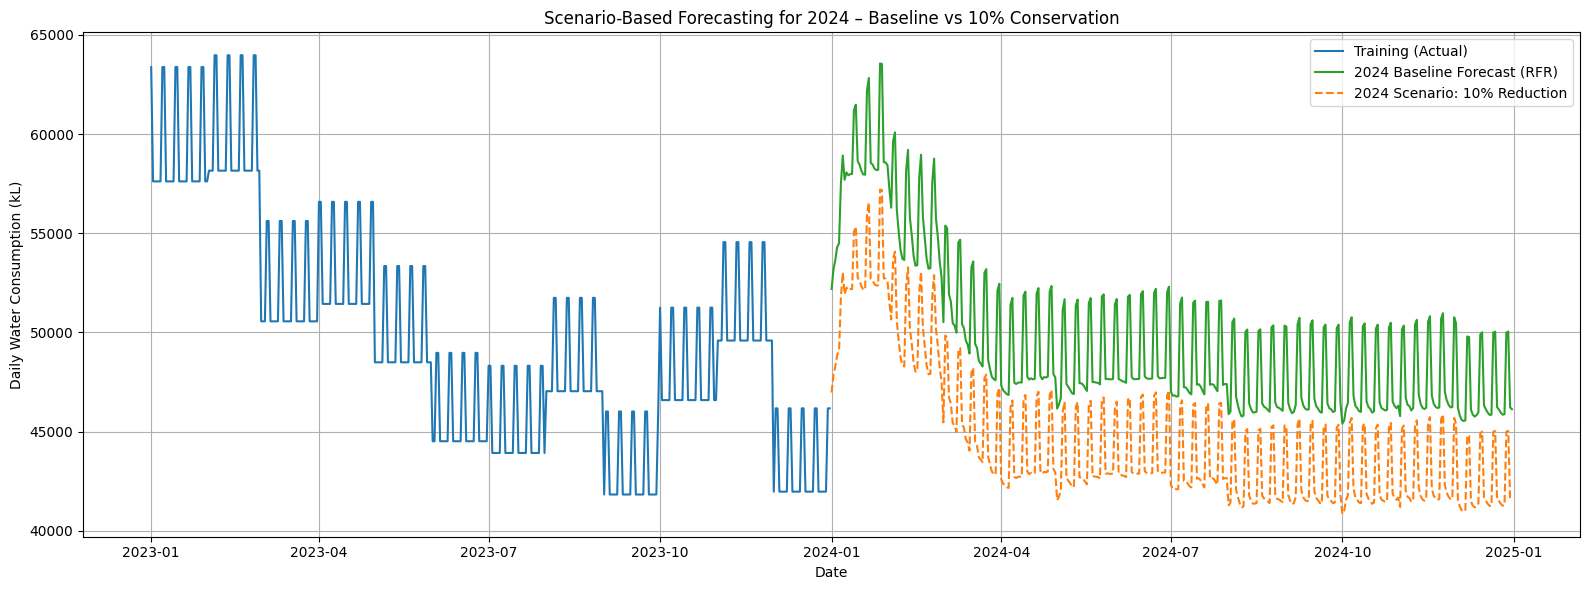

2024 Baseline total demand      : 18,174,003 kL
2024 Scenario (10% reduction)   : 16,356,603 kL
Absolute saving                 : 1,817,400 kL
Relative saving                 : 10.0%


In [ ]:
# =================================================
#  Scenario: 10% Reduction in Daily Demand (2024)
# =================================================

# 10% behavioural conservation scenario
forecast_2024['Conservation_10pct_kL'] = forecast_2024['Baseline_kL'] * 0.90

# For plotting: concatenate last year of training with 2024 forecast
train_tail = m_exog['Consumption_kL'].iloc[-365:]  # last 12 months of history

plt.figure(figsize=(16,6))

# Training history
plt.plot(train_tail.index, train_tail.values, label='Training (Actual)')

# 2024 Baseline forecast
plt.plot(forecast_2024.index, forecast_2024['Baseline_kL'],
         label='2024 Baseline Forecast (RFR)', color='tab:green')

# 2024 Conservation scenario (10% reduction)
plt.plot(forecast_2024.index, forecast_2024['Conservation_10pct_kL'],
         label='2024 Scenario: 10% Reduction', linestyle='--', color='tab:orange')

plt.title('Scenario-Based Forecasting for 2024 – Baseline vs 10% Conservation')
plt.xlabel('Date')
plt.ylabel('Daily Water Consumption (kL)')
plt.legend()
plt.tight_layout()
plt.show()

# =================================================
#  Summary numbers: annual totals & savings
# =================================================
baseline_total_2024   = forecast_2024['Baseline_kL'].sum()
scenario_total_2024   = forecast_2024['Conservation_10pct_kL'].sum()
absolute_saving_kL    = baseline_total_2024 - scenario_total_2024
percent_saving        = absolute_saving_kL / baseline_total_2024 * 100

print(f"2024 Baseline total demand      : {baseline_total_2024:,.0f} kL")
print(f"2024 Scenario (10% reduction)   : {scenario_total_2024:,.0f} kL")
print(f"Absolute saving                 : {absolute_saving_kL:,.0f} kL")
print(f"Relative saving                 : {percent_saving:,.1f}%")
